This notebook will walk through the reason that it is necessary to model response times, and the various ways to model them. We will start by generating a design that has trials that vary in reaction time.  This is adapted from Poldrack (2014, Developmental Cognitive Neuroscience).

In [52]:
import numpy
import nibabel
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.nonparametric.smoothers_lowess
import scipy
import nipype.algorithms.modelgen as model   # model generation
from nipype.interfaces.base import Bunch
from  nipype.interfaces import fsl
from statsmodels.tsa.arima_process import arma_generate_sample
import os,shutil

from nipype.caching import Memory
mem = Memory(base_dir='.')

def clearmem():
    for root, dirs, files in os.walk(mem.base_dir):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))
    
# generate the design at a higher temporal resolution
tr=0.1


First generate a design with four events that differ in their duration (by turning on the function for inreasing amounts of time).

In [53]:
variable_sf=numpy.zeros(1000)

variable_sf[100:102]=1
variable_sf[300:303]=1
variable_sf[500:505]=1
variable_sf[700:706]=1
variable_sf_conv=numpy.convolve(variable_sf,
                                spm_hrf(tr,oversampling=1))[0:len(variable_sf)]

Generate a beta-series design matrix that fits a separate regressor for each of the four trials; this is equivalent to separately modeling the intensity of each trial (assuming a constant duration for each).

In [54]:
hrf_bases=numpy.zeros((1000,4))
hrf_bases[100:104,0]=1
hrf_bases[300:304,1]=1
hrf_bases[500:504,2]=1
hrf_bases[700:704,3]=1
desmtx=numpy.zeros((1000,4))

for x in range(4):
    desmtx[:,x]=numpy.convolve(hrf_bases[:,x],
                               spm_hrf(tr,oversampling=1))[0:len(variable_sf)]

Now fit the beta-series model, and generate the fitted regressor.

In [55]:
b_est=numpy.linalg.inv(desmtx.T.dot(desmtx)).dot(desmtx.T).dot(variable_sf_conv)

intensity_sf_conv=desmtx.dot(b_est)

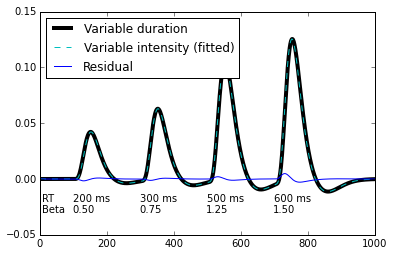

In [56]:
plt.clf()
plt.plot(variable_sf_conv,color='k',linewidth=4)
plt.hold(True)
plt.plot(intensity_sf_conv,'c--')
#plt.plot(constant_sf_conv,color='b')
plt.plot(intensity_sf_conv - variable_sf_conv,color='b')
plt.text(10,-0.02,'RT')
plt.text(100,-0.02,'200 ms')
plt.text(300,-0.02,'300 ms')
plt.text(500,-0.02,'500 ms')
plt.text(700,-0.02,'600 ms')
plt.text(10,-0.03,'Beta')
plt.text(100,-0.03,'%0.2f'%b_est[0])
plt.text(300,-0.03,'%0.2f'%b_est[1])
plt.text(500,-0.03,'%0.2f'%b_est[2])
plt.text(700,-0.03,'%0.2f'%b_est[3])

plt.axis([0,1000,-0.05,0.15])
plt.legend(['Variable duration','Variable intensity (fitted)','Residual'],
           loc='upper left')

The point to take away from this is that the variable duration and variable intensity have largely indistinguishable effects on the hemodynamic response, at least for relatively short events.

###Modeling reaction times

Now let's look at the various ways that one can model response times. First let's generate a design with two conditions that differ in mean response times. We will use a lognormal distribution which is a reasonable approximation to the shape of RT distributions.

Mean RT (condition 0): 1.08032222064
Mean RT (condition 1): 1.65911753524


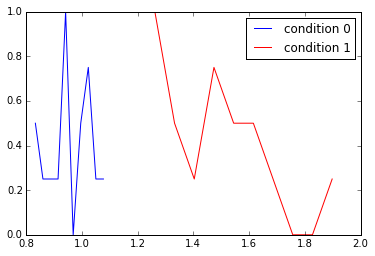

In [57]:
diff=0.5 # difference in RT across conditions
ntrials=32 #  trials per condition
condition=numpy.zeros(ntrials)
condition[ntrials/2:]=1 
rt=numpy.zeros(len(condition))
rt[condition==0]=numpy.random.lognormal(0.0,0.2,ntrials/2)
rt[condition==1]=numpy.random.lognormal(diff,0.2,ntrials/2)

#rt[:ntrials/2]+=rtdiff
h1=numpy.histogram(rt[condition==0])
plt.plot((h1[1][1:]+h1[1][:1])/2.0,h1[0]/float(numpy.max(h1[0])))
h2=numpy.histogram(rt[condition==1])
plt.plot((h2[1][1:]+h2[1][:1])/2.0,h2[0]/float(numpy.max(h2[0])),color='red')
print 'Mean RT (condition 0):',numpy.mean(rt[condition==0])
print 'Mean RT (condition 1):',numpy.mean(rt[condition==1])
plt.legend(['condition 0','condition 1'])
meanrt=numpy.mean(rt)

# generate random onsets

trial_length=16 # length of each trial, including ISI
total_length=trial_length*ntrials
randonsets=numpy.arange(0,total_length,trial_length)
numpy.random.shuffle(randonsets)
onsets=numpy.zeros(len(randonsets))
onsets[condition==0]=numpy.sort(randonsets[condition==0])
onsets[condition==1]=numpy.sort(randonsets[condition==1])



Now generate the data using these onsets and durations. We will generate three datasets:
* constant duration and activation across conditions
* variable duration but equal activation across conditions
* constant duration but unequal activation across condition

In [58]:
times=numpy.arange(0,total_length,1/100.)
deslen=len(times) # length of design in high-resolution (10 ms) space
sf_var=numpy.zeros(deslen)
sf_const=numpy.zeros(deslen)
sf_cond=numpy.zeros(deslen)
activation_effect=1

for i in range(len(onsets)):
    start=onsets[i]*100.
    stop_var=onsets[i]*100 + round(rt[i]*10)
    stop_const=onsets[i]*100 + round(numpy.mean(rt)*10)
    sf_var[start:stop_var]=1
    sf_const[start:stop_const]=1
    sf_cond[start:stop_const]=1+condition[i]*activation_effect # add activation effect

noiselevel=0.25
noise=arma_generate_sample([1,0.4],[1,0.],conv_sf_var.shape[0])*noiselevel
conv_sf_var=numpy.convolve(sf_var,spm_hrf(tr=0.01,oversampling=1.))[:len(sf_var)]
conv_sf_var=conv_sf_var[numpy.arange(0,len(conv_sf_var),100)]
data_var=conv_sf_var*50. + noise

conv_sf_const=numpy.convolve(sf_const,spm_hrf(tr=0.01,oversampling=1.))[:len(sf_const)]
conv_sf_const=conv_sf_const[numpy.arange(0,len(conv_sf_const),100)]
data_const=conv_sf_const*50. + noise

conv_sf_cond=numpy.convolve(sf_cond,spm_hrf(tr=0.01,oversampling=1.))[:len(sf_cond)]
conv_sf_cond=conv_sf_cond[numpy.arange(0,len(conv_sf_cond),100)]
data_cond=conv_sf_cond*50. + noise



First, build a model that assumes constant event durations

In [59]:
info = [Bunch(conditions=['cond0',
                          'cond1'],
              onsets=[numpy.sort(onsets[condition==0]),
                      numpy.sort(onsets[condition==1])],
              durations=[[meanrt],
                         [meanrt]])]

# create a dummy image for SpecifyModel to look at
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()

level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1.0,
                                    bases = {'dgamma':{'derivs': False}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)


INFO:workflow:Executing node 457b36f567b7b8d6be1bb4f1adc971c7 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/457b36f567b7b8d6be1bb4f1adc971c7
INFO:workflow:Executing node 9c042f7137633987722b80f656ff9327 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/9c042f7137633987722b80f656ff9327
INFO:workflow:Running: feat_model run0 


In [60]:
X=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
beta_hat_var_nort=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_var)
print 'Model with constant durations'
print 'betas for RT-related region',beta_hat_var_nort
beta_hat_const_nort=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_const)
print 'betas for RT-unrelated region',beta_hat_const_nort
beta_hat_cond_nort=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cond)
print 'betas for differential activation region',beta_hat_cond_nort


Model with constant durations
betas for RT-related region [ 4.09011182  6.3892164 ]
betas for RT-unrelated region [ 5.27395918  5.44017296]
betas for differential activation region [  5.23328696  10.75589927]


Note that the first two datasets have equal activation strengths, and thus their betas should be the same.  

Now build a model using the actual reaction times as regressors.

In [61]:
info = [Bunch(conditions=['cond0',
                          'cond1'],
              onsets=[onsets[condition==0],
                      onsets[condition==1]],
              durations=[rt[condition==0],
                         rt[condition==1]])]

# create a dummy image for SpecifyModel to look at
dummy=nibabel.Nifti1Image(numpy.zeros((12,12,12,total_length)),numpy.identity(4))
dummy.to_filename('tmp.nii.gz')
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1.0,
                                    bases = {'dgamma':{'derivs': False}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)


INFO:workflow:Executing node 64e746d40a0958d3522929b8b6afbe12 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/64e746d40a0958d3522929b8b6afbe12
INFO:workflow:Executing node 777c8dfa5824f127ec730b31f540c594 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/777c8dfa5824f127ec730b31f540c594
INFO:workflow:Running: feat_model run0 


In [62]:
X=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
beta_hat_var_rt=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_var)
print 'Model with variable durations'
print 'betas for RT-related region',beta_hat_var_rt
beta_hat_const_rt=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_const)
print 'betas for RT-unrelated region',beta_hat_const_rt
beta_hat_cond_rt=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cond)
print 'betas for differential actiation region',beta_hat_cond_rt


Model with variable durations
betas for RT-related region [ 5.20058392  5.3511747 ]
betas for RT-unrelated region [ 6.42330847  4.23827153]
betas for differential actiation region [ 6.29582551  8.33460501]


There are two thigns to notice here.  First, the RT-unrelated region now has an artifactual difference between conditions, driven by the differences in RT across conditions that are now included in the regressor.  Second, notice that the difference in activation between conditions in the third dataset (where one actually exists) is reduced compared to the previous model, because some of the effect is being removed due to its correlation with the RT difference across conditions.

Now let's build a model that includes a separate parametric regressor for RT alongside the constant regressor.

In [63]:
info = [Bunch(conditions=['cond0-const',
                          'cond1-const',
                         'RT'],
              onsets=[onsets[condition==0],
                      onsets[condition==1],
                     onsets],
              durations=[[meanrt],
                         [meanrt],
                          rt],
              amplitudes=[[1],[1],rt-meanrt]
                         )]

# create a dummy image for SpecifyModel to look at
dummy=nibabel.Nifti1Image(numpy.zeros((12,12,12,total_length)),numpy.identity(4))
dummy.to_filename('tmp.nii.gz')
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1.0,
                                    bases = {'dgamma':{'derivs': False}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)


INFO:workflow:Executing node c24336fc86452500b5c22ab945a91a2c in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/c24336fc86452500b5c22ab945a91a2c
INFO:workflow:Executing node 961c6b1f3aa98f0161525d76ef0c6d8f in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/961c6b1f3aa98f0161525d76ef0c6d8f
INFO:workflow:Running: feat_model run0 


In [65]:
X=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
beta_hat_var_param=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_var)
print 'Model with parametric RT effect'
print 'betas for RT-related region',beta_hat_var_param
beta_hat_const_param=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_const)
print 'betas for RT-unrelated region',beta_hat_const_param
beta_hat_cond_param=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cond)
print 'betas for differential activation region',beta_hat_cond_param


Model with parametric RT effect
betas for RT-related region [ 4.62714406  5.29299264  2.55864726]
betas for RT-unrelated region [ 5.32568151  5.33459411  0.24642691]
betas for differential activation region [  5.2840181   10.6523437    0.24170447]
